<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Schnoll_causal_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

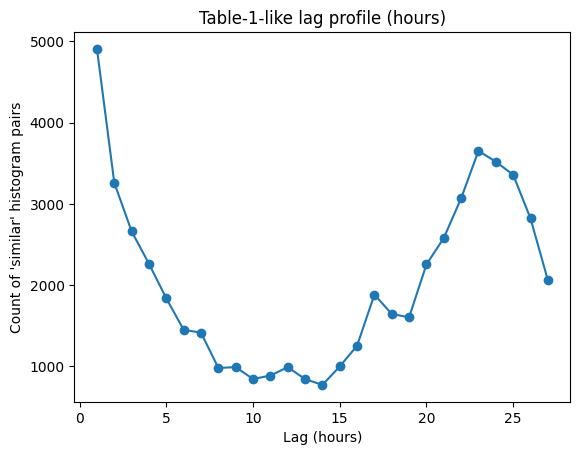

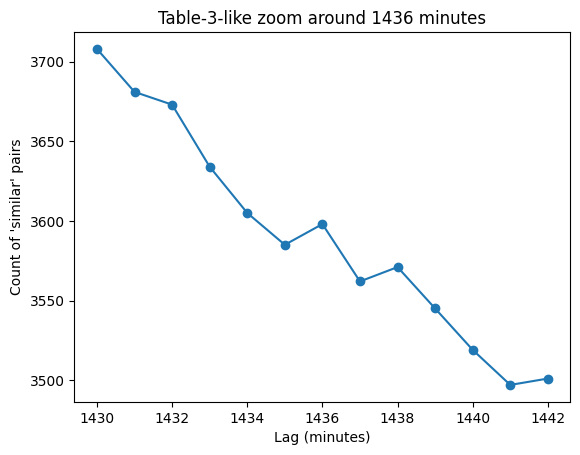

Similarity threshold theta = 0.9219257803493617


In [1]:
import numpy as np
from math import log
import matplotlib.pyplot as plt

# -----------------------------
# 1) Utilities: Jensen-Shannon similarity
# -----------------------------
def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    def kl(a, b):
        return np.sum(a * np.log(a / b))
    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

def js_similarity(p, q):
    # similarity in [0,1] (roughly); 1 means identical
    return 1.0 - js_divergence(p, q)

# -----------------------------
# 2) Build a causal kernel K(tau) (tau in seconds)
# -----------------------------
def build_kernel(dt, max_tau_s,
                 a=1.0, tau_c_s=3*3600,             # short memory
                 b=0.3, T_solar_s=1440*60, tau_solar_s=5*24*3600,  # solar day
                 c=0.5, T_sid_s=1436*60, tau_sid_s=7*24*3600,      # sidereal day
                 A=1.2, sigma_s=90.0):              # narrow resonance around Tsid
    # tau grid
    tau = np.arange(0, max_tau_s + dt, dt)

    K = np.zeros_like(tau, dtype=float)

    # Short memory exponential
    K += a * np.exp(-tau / tau_c_s)

    # Solar and sidereal oscillatory components with decay (causal, finite coherence)
    K += b * np.exp(-tau / tau_solar_s) * np.cos(2*np.pi*tau / T_solar_s)
    K += c * np.exp(-tau / tau_sid_s)   * np.cos(2*np.pi*tau / T_sid_s)

    # Narrow "mode" centered at Tsid (acts like a resonance in delay space)
    K += A * np.exp(-0.5 * ((tau - T_sid_s) / sigma_s) ** 2)

    # normalize kernel energy (optional, stabilizes epsilon)
    K /= (np.sqrt(np.sum(K**2)) + 1e-12)
    return K

# -----------------------------
# 3) Generate time series N(t): Poisson with log-rate modulated by filtered noise
# -----------------------------
def generate_series(duration_days=14,
                    dt=1.0,
                    lambda0=30.0,          # mean counts per second
                    epsilon=0.05,          # strength of modulation
                    kernel_max_tau_s=10*24*3600,
                    seed=0,
                    kernel_params=None):
    rng = np.random.default_rng(seed)
    T = int(duration_days * 24 * 3600 / dt)
    # driver noise (Gaussian)
    xi = rng.standard_normal(T)

    if kernel_params is None:
        kernel_params = {}

    K = build_kernel(dt, kernel_max_tau_s, **kernel_params)
    # causal convolution y(t) = sum_{tau>=0} K(tau) * xi(t - tau)
    # Implement via FFT for efficiency
    # (We do linear conv by padding)
    n = len(xi) + len(K) - 1
    nfft = 1 << (n - 1).bit_length()

    Xi = np.fft.rfft(xi, nfft)
    Kf = np.fft.rfft(K, nfft)
    y_full = np.fft.irfft(Xi * Kf, nfft)[:n]
    y = y_full[len(K)-1:len(K)-1+len(xi)]  # align causal part

    # log-rate modulation
    lam = lambda0 * np.exp(epsilon * y)
    # Poisson counts per dt (dt=1s => lam is per second)
    N = rng.poisson(lam * dt)
    return N, lam, K

# -----------------------------
# 4) Build Shnoll-style histograms from the series
# -----------------------------
def build_histograms(N, minute_bin=60, hist_len_minutes=60, n_bins=30, smooth=0):
    """
    N: counts per second
    minute_bin: aggregate to 1-minute totals (60s)
    hist_len_minutes: points per histogram (e.g., 60 points => 1 hour block)
    n_bins: bins of the histogram itself (distribution of those 60 points)
    smooth: moving average passes on the minute series (0 = none)
    """
    # aggregate to minute totals
    n_minutes = len(N) // minute_bin
    M = N[:n_minutes*minute_bin].reshape(n_minutes, minute_bin).sum(axis=1).astype(float)

    # optional smoothing (simple moving average)
    if smooth > 0:
        for _ in range(smooth):
            M = np.convolve(M, np.ones(3)/3.0, mode="same")

    # build a sequence of histograms
    Hs = []
    for i in range(0, n_minutes - hist_len_minutes + 1):
        block = M[i:i+hist_len_minutes]
        # histogram of the values inside this block
        # Use fixed range based on robust percentiles to reduce outlier sensitivity
        lo, hi = np.percentile(M, [1, 99])
        if hi <= lo:
            hi = lo + 1.0
        h, _ = np.histogram(block, bins=n_bins, range=(lo, hi), density=False)
        Hs.append(h.astype(float))
    Hs = np.array(Hs)
    return Hs

# -----------------------------
# 5) Similarity lag profile C(Δ): count how often histograms are "similar"
# -----------------------------
def lag_profile(Hs, max_lag, theta=None, target_rate=0.05, seed=0):
    """
    Hs: array [T_h, n_bins]
    max_lag: in histogram steps (each step = 1 minute shift if we used 1-minute stride)
    theta: similarity threshold; if None, choose it so global similar-rate ~ target_rate
    """
    rng = np.random.default_rng(seed)
    T_h = len(Hs)

    # If theta not given: sample random pairs to set threshold for target_rate
    if theta is None:
        samples = 20000 if T_h > 300 else 5000
        sims = []
        for _ in range(samples):
            i = rng.integers(0, T_h-1)
            j = rng.integers(0, T_h-1)
            sims.append(js_similarity(Hs[i], Hs[j]))
        sims = np.array(sims)
        theta = np.quantile(sims, 1.0 - target_rate)

    C = np.zeros(max_lag+1, dtype=int)
    Npairs = np.zeros(max_lag+1, dtype=int)

    for lag in range(1, max_lag+1):
        # compare H[i] with H[i+lag]
        n = T_h - lag
        Npairs[lag] = n
        cnt = 0
        for i in range(n):
            if js_similarity(Hs[i], Hs[i+lag]) > theta:
                cnt += 1
        C[lag] = cnt

    return C, Npairs, theta

# -----------------------------
# 6) Run a demonstration aiming at Table 1 + Table 3 signatures
# -----------------------------
if __name__ == "__main__":
    # Kernel params tuned to produce:
    # - short memory (hours)
    # - daily modulation
    # - sharp resonance near sidereal day (1436 min)
    kernel_params = dict(
        a=1.0, tau_c_s=2*3600,
        b=0.25, T_solar_s=1440*60, tau_solar_s=5*24*3600,
        c=0.35, T_sid_s=1436*60,  tau_sid_s=7*24*3600,
        A=1.4, sigma_s=60.0
    )

    N, lam, K = generate_series(duration_days=21, lambda0=25.0, epsilon=0.04,
                                kernel_max_tau_s=10*24*3600, seed=1,
                                kernel_params=kernel_params)

    # Build histograms: 1-min steps, 60-min block per histogram, 30 bins
    Hs = build_histograms(N, minute_bin=60, hist_len_minutes=60, n_bins=30, smooth=0)

    # --- Table 1-like: lag in hours up to 27 hours
    # Each histogram step = 1 minute shift, so 1 hour = 60 steps
    max_lag_hours = 27
    max_lag_steps = max_lag_hours * 60

    C, Npairs, theta = lag_profile(Hs, max_lag_steps, theta=None, target_rate=0.05, seed=2)

    # Convert to hours by sampling multiples of 60
    hours = np.arange(1, max_lag_hours+1)
    C_h = np.array([C[h*60] for h in hours])
    E_h = np.array([Npairs[h*60] for h in hours])

    plt.figure()
    plt.plot(hours, C_h, marker="o")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Count of 'similar' histogram pairs")
    plt.title("Table-1-like lag profile (hours)")
    plt.show()

    # --- Table 3-like: zoom around sidereal day (~1436 min)
    center = 1436  # minutes
    window = 6     # +/- minutes
    mins = np.arange(center-window, center+window+1)
    C_m = np.array([C[m] for m in mins])

    plt.figure()
    plt.plot(mins, C_m, marker="o")
    plt.xlabel("Lag (minutes)")
    plt.ylabel("Count of 'similar' pairs")
    plt.title("Table-3-like zoom around 1436 minutes")
    plt.show()

    print("Similarity threshold theta =", theta)
